# Preview

This notebook was inspired by the work done within the framework of the First International Summer School on Data Science for Mobility 2022, Santorini, Greece.

For more details and examples about the human mobility analysis and simulation in Python, please have a look at these [tutorials](https://github.com/scikit-mobility/tutorials/tree/master/DSM_summer_school).

In [3]:
from ckanapi import RemoteCKAN
import pandas as pd
import fiona
import requests
import io
import zipfile as zp
from zipfile import ZipFile 
from dbfread import DBF
from pandas import DataFrame
import sys
import csv
import json
import geopandas as gpd
import tabula
import networkx as nx
from owslib.wms import WebMapService
from owslib.wfs import WebFeatureService
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo, PropertyIsLike, BBox
from owslib.wcs import WebCoverageService
from owslib.ogcapi.features import Features
from owslib.ogcapi.coverages import Coverages
from owslib.ogcapi.records import Records
from owslib.ogcapi.processes import Processes
import xmlschema
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import folium
from SPARQLWrapper import SPARQLWrapper, JSON
from arcgis.gis import GIS
from IPython.display import display
from pandas_ods_reader import read_ods
import osmium as osm
import ezdxf
import matplotlib.pyplot as mplot  
import numpy as npy  
from rdflib import Graph
import networkx as nx
import osmnx as ox

## Searching for Datasets


### ckanapi Python Module

The ckanapi Python module may be used from within a CKAN extension or in a Python 2 or Python 3 application separate from CKAN.

First of all, we start by searching for packages satisfying given search criteria. For that, we use the function action.package_search() which accepts solr search query parameters (for more in depth treatment of each paramter, please read 
[the Solr documentation](https://solr.apache.org/guide/6_6/common-query-parameters.html)) and returns a dictionnary with the following keys:

 - **count (int)** – the number of results found. Note, this is the total number of results found, not the total number of results returned (which is affected by limit and row parameters used in the input).
 
- **results (list of dictized datasets)** – ordered list of datasets matching the query, where the ordering defined by the sort parameter used in the query.


- **search_facets (nested dict of dicts)** – aggregated information about facet counts. The outer dict is keyed by the facet field name (as used in the search query). Each entry of the outer dict is itself a dict, with a “title” key, and an “items” key. The “items” key’s value is a list of dicts, each with “count”, “display_name” and “name” entries. The display_name is a form of the name that can be used in titles.

For more information about the Action API reference, have a look at the [CKAN official documentation](https://docs.ckan.org/en/2.9/api/#ckan.logic.action.get.package_search).

The example below is using an "action shortcut". The .action object detects the method name used ("package_search" below) and converts it to a normal call_action call.

In [ ]:
#Making a request. We use the apikey parameter to supply the CKAN API key to RemoteCKAN

demo = RemoteCKAN('http://processor1.francecentral.cloudapp.azure.com', apikey='da5b4ea3-1a99-4807-a3c0-a0e3467894ff')

# the 'q' parameter stands for the solr query. here for example we search for datasets that have the word 'bus' in the title
packages = demo.action.package_search(q='bus', rows=1000)
                                                          
print("count results : " + str(len(packages["results"]))+" datasets")

count results : 61 datasets


In [ ]:
#extract the name, URL and format of a dataset

def data_infos(keys, name, url, uri, format):

  print("Name of the dataset : " + str(name))

  #the key "format" doesn't always contain the actual format of a dataset. For example, a dataset could be a GeoJSON, but is registered as JSON. To overcome this issue, we also
  #verify the format of a file based on its URIs (since, in most cases, the URIs contains the extention of the file at the end)
  
  #list of the 'basic' file formats. Will be used later on this code to filter the URIs that contain alphanumeric caracters instead of file formats at the end.
  
  data_formats =["csv", "txt", "json", "geojson", "api", "shp", "shapefiles", "zip", "html"]  
  data_f = True

  data_url=url
  print("Data url : " + data_url)

  if ("uri" in keys):
      data_format=uri.split("-")
      if (data_format not in data_formats):
          data_F = False
      data_format=data_format[-1].lower()
            
  if ("format" in keys or data_F == False):  
      data_F = True
      data_format=format.split("/")
      data_format=data_format[-1].lower()

  print("Data format : " +data_format)
    

In [ ]:
#In the following example, we are trying to extract informations about the first file ressource of the first dataset of our privious search about buses

k = packages["results"][0].keys() 
print("list of the dataset's metadata: " + str(k)) #metadata related to the first dataset of our privious search about buses
print('----------------------')
keys = packages["results"][0]["resources"][0].keys()
print("list of the file ressource's metadata: " + str(keys)) #metadata related to the first file ressource of the first dataset of our privious search about buses
print('----------------------')
name = packages["results"][0]["resources"][0]["name"]
url = packages["results"][0]["resources"][0]["url"]
uri = packages["results"][0]["resources"][0]["uri"]
format = packages["results"][0]["resources"][0]["format"]

data_infos(keys, name, url, uri, format)

list of the dataset's metadata: dict_keys(['author', 'author_email', 'creator_user_id', 'id', 'isopen', 'license_id', 'license_title', 'maintainer', 'maintainer_email', 'metadata_created', 'metadata_modified', 'name', 'notes', 'num_resources', 'num_tags', 'organization', 'owner_org', 'private', 'state', 'title', 'type', 'url', 'version', 'extras', 'resources', 'tags', 'groups', 'relationships_as_subject', 'relationships_as_object'])
----------------------
list of the file ressource's metadata: dict_keys(['access_url', 'cache_last_updated', 'cache_url', 'created', 'description', 'distribution_ref', 'format', 'hash', 'id', 'issued', 'language', 'last_modified', 'license', 'metadata_modified', 'mimetype', 'mimetype_inner', 'modified', 'name', 'package_id', 'position', 'resource_type', 'rights', 'size', 'state', 'uri', 'url', 'url_type'])
----------------------
Name of the dataset : json
Data url : https://data.laregion.fr/api/v2/catalog/datasets/arrets-de-bus/exports/json
Data format : js

## Reading Datasets



Download the data to a DataFrame. We use seperate function calls, depending on the format of the dataset. More details about the following formats, along with their extensions and other associated formats are available at [this link.](https://docs.fileformat.com/)

**NB**: the storage of geographic data differs from one format /dataset to another. Indeed, sometimes the data is in the form of a list, other times we have dictionaries, or strings, or points, etc.
The safest way is to display the data once it is extracted so that we know how to handle it afterwards.

### CSV/TXT

Files with **Comma Separated Values (CSV)** extension represent plain text files that contain records of data with comma separated values. Each line in a CSV file is a new record from the set of records contained in the file. Such files are generated when data transfer is intended from one storage system to another. 

A file with **.TXT extension** represents a text document that contains plain text in the form of lines. The default character set of text files is ASCII that is used for creating and display of text file contents. Characters are encoded using ASCII character set, but this imposes limitation of usage on characters such as Pound Sign, Dollar and Euro sign that can’t be represented using the ASCII character set. Thus, text files can also be saved in Unicode format, with UTF-8 being the mostly used. Text files can also store large amount of data as there is no limitation on the size of contents. A standard text document can be opened in any text editor or word processing application on different operating systems. 



In [ ]:
def read_csv(data_url):   #same function is applicable for '.txt' files
    try:
        df = pd.read_csv(data_url, sep=';')
    except Exception as e:
        print('Sorry, could not handle the csv file. Please check parameters (URL, etc.). Error : ' + str(e))       

### XML/PHP

The **Extensible Markup Language (XML)** is similar to HTML but different in using tags for defining objects. The whole idea behind this format is to use a universal language for data communication over the network by making data transport and platform changes simplified. This also makes sure exchange data between incompatible systems possible by storing data in plain text format. HTML is for data representation over the web, whereas XML is for exchange of data. The markup tag pairs used inside XML define the key elements of the structure to be utilized by reading applications.


 

On the other hand, a file with **.php** extension refers to open source programming language, used to write server side scripts, to be executed on a web server. The result is returned to the browser as plain HTML. PHP files can be opened with any text editor and edited in place, though applications like Adobe Dreamweaver, Eclipse PHP Development tools offer a convenient way to write and modify PHP code.

In [ ]:
def read_xml(data_url):   #same function is applicable for files that end with '.php'
    try:
        df=pd.read_xml(data_url)
    except Exception as e:
        print('Sorry, could not handle the xml file. Please check parameters (URL, etc.). Error : ' + str(e))

### OSM/PBF


OSM file parsing by osmium is built around the concept of handlers. A handler is a class with a set of callback functions. Each function processes exactly one type of object as it is read from the file.

A handler has to inherit from one of the handler classes (in our case osmium.SimpleHandler). Then it needs to implement functions for each object type it wants to process.

After that, the handler needs to be applied to an OSM file, and that is by calling the apply_file() convenience function, which in its simplest form only requires the file name as a parameter.

For more detais, have a look at [the official documentation of OSMIUM.](https://docs.osmcode.org/pyosmium/latest/index.html)

In [ ]:
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)

In [ ]:
osmhandler = OSMHandler()
osmhandler.apply_file("greece-latest.osm.pbf")

### ODS

**OpenDocument Spreadsheet (ODS)** is a XML-based format and is one of the several subtypes in the Open Document Formats (ODF) family. The format supports document representation as a single XML document as well as a collection of several subdocuments within a package as ZIP archive.  Each of the files from the ZIP archive stores part of the complete document. Each subdocument stores a particular aspect of the document. For example, one subdocument contains the style information and another subdocument contains the content of the document.

In [ ]:
def read_ods(data_url):
    try:
        df = read_ods(data_url)
        print(df)
    except Exception as e:
        print('Sorry, could not handle the ODS file. Please check parameters (URL, etc.). Error : ' + str(e))        

### XSD

An **XML schema definition (XSD)** is a framework document that defines the rules and constraints of an XML document. This ensures that data is properly interpreted, and errors are caught, resulting in appropriate XML validation. XSD files ensure that the data entered follows the same structure as defined in the file. XSD files are stored in XML file format and can be opened or edited in any text editor.

In [ ]:
def read_xsd(data_url):
    try:
        my_schema = xmlschema.XMLSchema(data_url)
        print(my_schema)
        #pprint(xs.to_dict('tests/test_cases/examples/collection/collection.xml'))
    except Exception as e:
        print('Sorry, could not handle the xsd file. Please check parameters (URL, etc.). Error : ' + str(e))   

### XLS/XLSX

Files with XLS extension represent **Excel Binary File Format**. Just like the CSV format, a file saved by Excel is known as Workbook where each workbook can have one or more worksheets. Data is stored and displayed to users in table format in worksheet and can span numeric values, text data, formulas, external data connections, images, and charts.
 

In [ ]:
def read_xls(data_url):   #same function is applicable for the "xlsx" format
    try:
        df=pd.read_excel(data_url)
    except Exception as e:
        print('Sorry, could not handle the xls file. Please check parameters (URL, etc.). Error : ' + str(e))

### JSON/DORA-Service/GBFS

The **JavaScript Object Notation (JSON)** is an open standard file format for sharing data that uses human-readable text to store and transmit data. It is derived from JavaScript but is a language-independent data format. 

JSON data is written in key/value pairs. The key and value are separated by a colon(:) in the middle with the key on the left and the value on the right. Different key/value pairs are separated by a comma(,). The key is a string surrounded by double quotation marks for example “name”. 


In [ ]:
def read_json(data_url):  #same function is applicable for the "DORA-Service"/"GBFS" formats
    try:
        df = pd.read_json(data_url)
        print(df.head())
    except Exception as e:
        print('Sorry, could not handle the json file. Please check parameters (URL, etc.). Error : ' + str(e))

### GeoJSON/SHP/GPKG

**GeoJSON** is a JSON based format designed to represent the geographical features with their non-spatial attributes. It represents a collective information about the Geographical features, their spatial extents, and properties. An object of this file may indicate a geometry (Point, LineString, Polygon), a feature or collection of features. The features reflect addresses and places as point’s streets, main roads and borders as line strings and countries, provinces, and land regions as polygons. 

In [ ]:
def read_geojson(data_url):      #same function is applicable for the- 'shp' and 'gpkg' format
    try:
        df = gpd.read_file(data_url)
        print(df.head())
    except Exception as e:
        print('Sorry, could not handle the geojson file. Please check parameters (URL, etc.). Error : ' + str(e))    

### HTML

The **Hyper Text Markup Language (HTML)** is the extension for web pages created for display in browsers. HTML pages are either received from server, where these are hosted, or can be loaded from local system as well. Each HTML page is made up of HTML elements such as forms, text, images, animations, links, etc. These elements are represented by tags and several others where each tag has start and end. It can also embed applications written in scripting languages such as JavaScript and Style Sheets (CSS) for overall layout representation.

In [ ]:
def read_html(data_url): 
    try:
        table = pd.read_html(data_url)
    except Exception as e:
            print('Sorry, could not handle the html file. Please check parameters (URL, etc.). Error : ' + str(e))

### API

An **application programming interface (API)** is a way for two or more computer programs to communicate with each other. It is a type of software interface, offering a service to other pieces of software. document or standard that describes how to build or use such a connection or interface is called an API specification. A computer system that meets this standard is said to implement or expose an API. The term API may refer either to the specification or to the implementation.

In [ ]:
def read_api(data_url):
    try:
        response_API = requests.get(data_url)
        data = response_API.text 
        parse_json = json.loads(data)
        df = pd.DataFrame.from_dict(pd.json_normalize(parse_json), orient='columns') 
    except Exception as e:
        print('Sorry, could not access to this api. Please check parameters (URL, etc.). Error : ' + str(e))   

### ZIP

A file with **.zip extension** is an archive that can hold one or more files or directories. The archive can have compression applied to the included files in order to reduce the ZIP file size.

In [4]:
def unzip_files_url(data_url): #unzip a file coming from an internet source
    try:
        r = requests.get(data_url)
        z = ZipFile(io.BytesIO(r.content))
        z.extractall()
        filenames = [y for y in sorted(z.namelist())]
        print(filenames)
        return filenames
    except Exception as e:
             print('Sorry, could not handle the zip file. Please check parameters (URL, etc.). Error : ' + str(e))    

In [66]:
def unzip_files(filename):
    with ZipFile(filename, 'r') as zObject:    
        # Extracting all the members of the zip into a specific location.
        zObject.extractall()
        filenames = [y for y in sorted(zObject.namelist())]
        print(filenames) 
        return filenames

### OGC

The **Open Geospatial Consortium (OGC)** is an international consortium of more than 500 businesses, government agencies, research organizations, and universities driven to make geospatial (location) information and services *FAIR - Findable, Accessible, Interoperable, and Reusable*.

They are used by software developers to build open interfaces and encodings into their products and services. Standards are the main "products" of OGC and have been developed by the membership to address specific interoperability challenges, such as publishing map content on the Web, exchanging critical location data during disaster response & recovery, and enabling the fusion of information from diverse Internet of Things (IoT) devices. 

For more informations, see also [this link.](https://www.ogc.org/standards)

### KML

**Keyhole Markup Language (KML)** is a type of language tag, inspired by XML, which incorporates in an ASCII (text) file the geometric descriptions of points, lines and polygons, as well as attribute data like longitude and latitude, in addition to other data can make a view more specific, such as tilt, heading, or altitude, which together define a "camera view" along with a timestamp or timespan. The geographic annotation and visualization can be done within two-dimensional maps and three-dimensional Earth browsers.

For more informations, see also [this link.](https://en.wikipedia.org/wiki/Keyhole_Markup_Language)

In [ ]:
def read_kml(data_url):
    try:
        gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
        df = gpd.read_file(data_url, driver='KML')
    except Exception as e:
            print('Sorry, could not handle the kml file. Please check parameters (URL, etc.). Error : ' + str(e))

### GML/XPLANGML


Similar to KML format, the **The Geography Markup Language (GML)** consists of a set of XML schemas that define an open format for the exchange of geographic data and allow the construction of specific data models for specialized domains, such as urban planning, hydrology or geology.

For more informations, have a look at [this link.](https://www.ogc.org/standards/gml)

In [ ]:
def read_gml(data_url):    #same function is applicable for the "xplangml" format
    try:
        df = gpd.read_file(data_url, driver='GML')
    except Exception as e:
        print('Sorry, could not handle the gml file. Please check parameters (URL, etc.). Error : ' + str(e))

### GIS

A **Geographic Information System (GIS)** is a type of database containing geographic data, combined with software tools for managing, analyzing, and visualizing those data. 

The core of any GIS is a database that contains representations of geographic phenomena (such as roads, land use, elevation, trees, waterways, and states), modeling their geometry (location and shape) and their properties or attributes. A GIS database may be stored in a variety of forms, such as a collection of separate data files or a single spatially-enabled relational database. 

For more informations about the standard, see also [this link](https://en.wikipedia.org/wiki/Geographic_information_system) and [this one.](https://www.gistandards.eu/gis-standards/#:~:text=What%20are%20GIS%20standards%3F,use%20of%20any%20geographic%20information.) 

To perform GIS visualization, analysis, data management, and GIS system administration task, we use the ArcGIS API library. To explore this library more in details, have a look at [Documentation and samples for ArcGIS API for Python](https://github.com/Esri/arcgis-python-api). For more informations about the GIS module (parameters, examples, etc.), see also [this link.](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#gis)

In [ ]:
def read_gis(data_url, city, query):
    
    try:
        
        #The GIS Object provides a mapping widget that can be used in the Jupyter Notebook environment for visualizing GIS 
        #content as well as the results of your analysis.

        gis = GIS(url=data_url) # data_url is an Optional string. 
                                #If URL is None, then the URL will be ArcGIS Online. This should be a web address to either an ArcGIS Enterprise portal 

        map1 = gis.map(city) #The GIS object includes a map widget that can be used to visualize the content of your 
                         #GIS as well as see the results of your analysis. 
        print("Displaying the map of " +city)
        display(map1)

        #We can search for content in our GIS. We do that by calling gis.content.search() and for each web map or web layers that gets 
        #returned, we can display its rich representation within the notebook

        print("Searching for " + query)
        items = gis.content.search(query, item_type="Feature Layer", outside_org=True)
        for item in items[:5]:
            display(item) #print the first 5 results of the search
            
    except Exception as e:
             print('Sorry, could not handle the GIS API. Please check parameters (URL, etc.). Error : ' + str(e)) 

In [ ]:
#Example of using GIS API

read_gis(None, "New York", "New York Bicycle")

Displaying the map of New York


MapView(layout=Layout(height='400px', width='100%'))

Searching for New York Bicycle


<Item title:"NY_MONROE_RECREATION_TRAILS" type:Feature Layer Collection owner:epd_llc>

<Item title:"NY_STATE_BIKEROUTES" type:Feature Layer Collection owner:epd_llc>

<Item title:"Cycling Facility" type:Feature Layer Collection owner:Jim_GObike>

<Item title:"BikeRacks NYC" type:Feature Layer Collection owner:sarah_wma>

<Item title:"NYC CBSA 2018 Spending on Parking and Tolls" type:Feature Layer Collection owner:CVaillancourt_EsriMedia>

### WMS

**The Web Map Service (WMS)** is a standard protocol developed by the Open Geospatial Consortium (OGC) for serving georeferenced map images over the Internet. These images are typically produced by a map server from data provided by a GIS database. 

A WMS server usually serves the map in a bitmap format, e.g. PNG, GIF, JPEG, etc. In addition, vector graphics can be included, such as points, lines, curves and text, expressed in SVG or WebCGM format.

WMS specifies a number of different request types, two of which are required by any WMS server:

- GetCapabilities: returns parameters about the WMS (such as map image format and WMS version compatibility) and the available layers (map bounding box, coordinate reference systems, URI of the data and whether the layer is mostly opaque or not)


- GetMap: returns a map image. Parameters include: width and height of the map, coordinate reference system, rendering style, image format

For more details, have a look at [this link.](https://en.wikipedia.org/wiki/Web_Map_Service#:~:text=A%20Web%20Map%20Service%20(WMS,provided%20by%20a%20GIS%20database)

In [ ]:
#functions related to the WMS standard 

def wms_details(wms, layer):      #details of a layer
     
    print("name of the layer : " + wms[layer].title)   
    print("queryable : " + str(wms[layer].queryable))
    print("opacity : " + str(wms[layer].opaque))
    print("bounding box : " + str(wms[layer].boundingBox))
    print ("bounding boxWGS84 : " + str(wms[layer].boundingBoxWGS84))
    print("crsOptions : " +str(wms[layer].crsOptions))
    print("styles : " + str(wms[layer].styles)) #pseudo_bright, visual, pseudo_low, etc.
          
def wms_methods(wms, methods):
          
    for m in range(len(methods)): 
        print("method : " + methods[m])
        urls=wms.getOperationByName(methods[m]).methods
        formats=wms.getOperationByName(methods[m]).formatOptions # image/jpeg, image/png, image/geotiff, image/tiff, etc.
        print("Formats : " +str(formats))
        print('---------------------------')
        
        
def wms_visualisation(layer,style,crsOptions, boundingBox, size, fmt, name):

    img = wms.getmap(layers=layer,
                         styles=style,
                         srs=crsOptions,
                         bbox=boundingBox,
                         size=size, #for example : (300, 250)
                         format= fmt,
                         transparent=True)
                        
    out = open(name, 'wb')
    out.write(img.read())
    out.close()
 
def wms_main(data_url):
    
    #Connect to a WMS, and inspect its properties
    wms = WebMapService(data_url)
    title = wms.identification.title #name of the dataset          
    layers = list(wms.contents) #available layers 
    for i in range(len(layers)):
        wms_details(wms, layers[i])
        print('---------------------------')
    operations = [op.name for op in wms.operations]
    wms_methods(wms, operations)
    #wms_visualisation(layers[0], 'default','EPSG:4258', (3.8356, 50.757, 7.21, 53.446), (300, 250),'image/png', 'test.jpg')
    

In [ ]:
wms_main(data_url)

name of the layer : Fachlayer
queryable : 0
opacity : 0
bounding box : (275474.3136716059, 5249458.19064818, 948952.0949152961, 6112217.801847044, 'EPSG:3044')
bounding boxWGS84 : (6.02439799999999, 47.398578, 14.950565, 55.010987)
crsOptions : ['EPSG:3044', 'EPSG:900913', 'EPSG:31468', 'EPSG:25833', 'EPSG:4326', 'EPSG:25832', 'EPSG:4258', 'EPSG:3045', 'EPSG:1000001', 'EPSG:3857', 'EPSG:4839', 'EPSG:3413', 'EPSG:31467']
styles : {}
---------------------------
name of the layer : Wetter
queryable : 0
opacity : 0
bounding box : (275474.3136716059, 5249458.19064818, 948952.0949152961, 6112217.801847044, 'EPSG:3044')
bounding boxWGS84 : (6.02439799999999, 47.398578, 14.950565, 55.010987)
crsOptions : ['EPSG:3044', 'EPSG:900913', 'EPSG:31468', 'EPSG:25833', 'EPSG:4326', 'EPSG:25832', 'EPSG:4258', 'EPSG:3045', 'EPSG:1000001', 'EPSG:4839', 'EPSG:31467', 'EPSG:3413', 'EPSG:3857']
styles : {}
---------------------------
name of the layer : Beobachtungen
queryable : 0
opacity : 0
bounding box : 

### CSW

**Catalogue Service for the Web (CSW)** is a standard for exposing a catalogue of geospatial records in XML on the Internet (over HTTP). The catalogue is made up of records that describe geospatial data (e.g. KML), geospatial services (e.g. WMS), and related resources.

Each record must contain certain core fields including: Title, Format, Type (e.g. Dataset, DatasetCollection or Service), BoundingBox (a rectangle of interest, expressed in latitude and longitude), Coordinate Reference System, and Association (a link to another metadata record).

Operations defined by the CSW standard include:

- *GetCapabilities*: allows CSW clients to retrieve service metadata from a server

- *DescribeRecord*: allows a client to discover elements of the information model supported by the target catalogue service. The operation allows some or all of the information model to be described.

- *GetRecords*: search for records, returning record IDs

- *GetRecordById*: retrieves the default representation of catalogue records using their identifier

- *GetDomain (optional)*: "used to obtain runtime information about the range of values of a metadata record element or request parameter"

For more details, have a look at [this link](https://www.ogc.org/standards/cat) and [this one.](https://en.wikipedia.org/wiki/Catalogue_Service_for_the_Web)

In [ ]:
#functions related to the csw standard 

def csw_search_data(data, nb_results):
    
    #Search for a specific data, for example: search for bird data
    query = PropertyIsEqualTo('csw:AnyText', data)
    csw.getrecords2(constraints=[query], maxrecords=nb_results) # return n results out of all, for ex: nb_results=20
    print(csw.results)
    for rec in csw.records:
        print(csw.records[rec].title)
        
def csw_search_data_place(data, bbox):
    
    #Search for a specific data in a specific place, for example: search for bird data in Canada
    bbox_query = BBox(bbox) # for ex: bbox = [-141,42,-52,84]
    query =  PropertyIsEqualTo('csw:AnyText', data)
    csw.getrecords2(constraints=[query, bbox_query])
    print(csw.results)

def csw_search_like_keywords(keyword):
    
    #Search for keywords
    query_like = PropertyIsLike('dc:subject', '%'+keyword+'%') #for ex: PropertyIsLike('dc:subject', '%birds%')
    csw.getrecords2(constraints=[query_like])
    print(csw.results)
  
def csw_main(data_url):
    
    #Connect to a CSW, and inspect its properties
    csw = CatalogueServiceWeb(data_url) 
    csw_operations=[op.name for op in csw.operations]
    print(csw_operations)
    try:
        for i in range(len(csw_operations)): #get supported resultType’s of each operation              
            csw.getdomain(csw_operations[i]+'.resultType')
            print(csw.results)
    except:
            print('Sorry, could not get the resultType. Please check the csw_operation')


### WCS

The **Web Coverage Service (WCS)** is a standard that provides an interface for downloading coverage data (digital terrain models, orthoimages, numerical weather prediction).

For more details, have a look at [this link.](https://www.ogc.org/standards/wcs)

In [ ]:
#functions related to the wcs standard 

def wcs_main(data_url):
    
    # Create coverage object
    my_wcs = WebCoverageService(data_url)

    # Get list of coverages
    coverages=my_wcs.contents.keys()
    print(coverages)

    
    for i in range(len(coverages)):
        wcs_covrages(covrages[i])
               
def wcs_covrages(covrage): # Get geo-bounding boxes and native CRS of coverages
    
    boudingboxes = my_wcs.contents[coverage].boundingboxes

    # Get axis labels
    axislabels = my_wcs.contents[coverage].grid.axislabels

    # Get dimension
    dimension = my_wcs.contents[coverage].grid.dimension

    # Get grid lower and upper bounds
    lowlimits = my_wcs.contents[coverage].grid.lowlimits
    highlimits = my_wcs.contents[coverage].grid.highlimits

    # Get offset vectors for geo axes
    offsetvectors= my_wcs.contents[coverage].grid.offsetvectors

    # For coverage with time axis get the date time values
    timepositions = my_wcs.contents[coverage].timepositions
    

### WFS

The **Web Feature Service (WFS)** allows, by means of a formatted URL, to query map servers in order to manipulate geographic objects (lines, points, polygons...), contrary to the Web Map Service or WMS which allows the production of georeferenced maps from geographic servers.

For more details, have a look at [this link](https://en.wikipedia.org/wiki/Web_Feature_Service) and [this link.](https://geopython.github.io/OWSLib/usage.html#wfs)

In [ ]:
def read_wfs(data_url): 
    try:
        wfs = WebFeatureService(url=data_url) #Connect to a WFS and inspect its capabilities
        print(wfs.identification.title)
        operations = [operation.name for operation in wfs.operations]
        print(operations)
        contents = list(wfs.contents) #List FeatureTypes
        print(contents)
    except Exception as e:
        print('Sorry, could not handle the wfs file. Please check parameters (URL, etc.). Error : ' + str(e))

In [ ]:
read_wfs(data_url)

DWD GeoServer WFS
['GetCapabilities', 'DescribeFeatureType', 'GetFeature', 'Transaction', 'LockFeature', 'GetFeatureWithLock']
['dwd:RBSN_RR']
Sorry, could not handle the wfs file. Please check parameters (URL, etc.). Error : 'WebFeatureService_1_0_0' object has no attribute 'storedqueries'


### SPARQL

SPARQL is the standard query language and protocol for Linked Open Data and RDF databases. SPARQL can be used to add, remove and retrieve data from RDF-style graph databases. 

SPARQL queries can not only match patterns of subject-predicate-object triples, but can also use mathematical operations (*JOIN, SORT, AGGREGATE,etc.*) and a wide range of utility functions to create filters and new variable bindings. 

In [ ]:
def read_sparql(data_url, query):
    try:   
        sparql = SPARQLWrapper(data_url)
        sparql.setQuery(query)
        #The response from the given endpoint is retrieved in JSON and converted to a Python object, 
        #ret, which is then iterated over and printed        
        ret = sparql.queryAndConvert()
        for r in ret["results"]["bindings"]: 
            print(r)
    except Exception as e:
         print('Sorry, could not handle the SPARQL file. Please check parameters (URL, etc.). Error : ' + str(e))
            

### PDF

**tabula-py** is a simple Python wrapper of tabula-java, which enables you to extract tables from a PDF into a DataFrame, or a JSON. It can also extract tables from a PDF and save the file as a CSV, a TSV, or a JSON.    

In [ ]:
def read_pdf(data_url):
    try:
        df = tabula.read_pdf(data_url)
    except Exception as e:
         print('Sorry, could not handle the PDF file. Please check parameters (URL, etc.). Error : ' + str(e))

### TIFF

The **Tag Image File Format (TIFF)** is an image file format for storing images that are rasterized.

The following step-by-step implementation was taken from [this tutorial.](https://www.javatpoint.com/visualize-tiff-file-using-matplotlib-and-gdal-in-python)

In [68]:
from osgeo import gdal as GD  

file=unzip_files('387122.zip')

['387122/', '387122/387122.tfw', '387122/387122.tif']


In [72]:
data_set = GD.Open(file[2]) 

In [80]:
print("Number of bands: " + str(data_set.RasterCount))  #Counting the total number of bands

Number of bands: 3


In [74]:
# Fetching the bands. As, there are 3 bands, We will store in 3 different variables.
# We utilize the GDAL's GetRasterBand(int) to get the bands. 
#It is important to note that the value that we pass will always begin with one (indexing of bands starts at 1) 

band_1 = data_set.GetRasterBand(1) # red channel  
band_2 = data_set.GetRasterBand(2) # green channel  
band_3 = data_set.GetRasterBand(3) # blue channel  

In [75]:
#Step 4: Reading the bands as NumPy arrays.

b1 = band_1.ReadAsArray()  
b2 = band_2.ReadAsArray()  
b3 = band_3.ReadAsArray()  

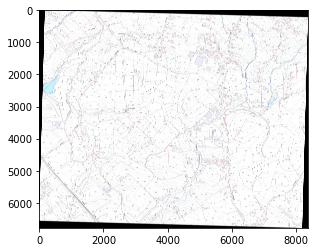

In [76]:
# Plotting the arrays using imshow() function of matplotlib. In our case, for plotting the three arrays, we'll stack them up in order.

img_1 = npy.dstack((b1, b2, b3))  
f = mplot.figure()  
plt.imshow(img_1)  
mplot.savefig('Tiff.png')  
mplot.show()  

### DXF

The **Drawing Interchange File (DXF)** format stores and describes the content of 2D and 3D design data and metadata. All graphical DXF entities are stored in layouts; these layouts can be iterated and do support the index operator. A layout can contain entities like LINE, CIRCLE, TEXT and so on. Each DXF entity can only reside in exact one layout.

There are three different layout types:

- **Modelspace:** the common construction space
- **Paperspace:** used to to create print layouts
- **BlockLayout:** reusable elements, every block has its own entity space

A DXF document consist of exact one modelspace and at least one paperspace. The modelspace contains the “real” world representation of the drawing subjects in real world units.

For more information, have a look at [the official documentation.](https://ezdxf.readthedocs.io/en/stable/index.html)


In [33]:
from google.colab import files
uploaded_files = files.upload()

Saving 336152_plt.zip to 336152_plt.zip


In [52]:
# helper function
def print_entity(e):
    print("LINE on layer: %s\n" % e.dxf.layer)
    print("start point: %s\n" % e.dxf.start)
    print("end point: %s\n" % e.dxf.end)
    print('-------------------------')

def read_ezdxf(filename, zipname):

    try:
      #ezdxf supports loading ASCII and binary DXF documents from a file or a ZIP-file

      #doc = ezdxf.readfile(filename)
      doc = ezdxf.readzip(zipname, filename )
      msp = doc.modelspace()  # Getting the modelspace of the DXF document and iterate over all entities 
      for e in msp:
        if e.dxftype() == "LINE":
          print_entity(e)

      # entity query for all LINE entities in modelspace
      for e in msp.query("LINE"):
        print_entity(e)

    except IOError:
        print(f"Not a DXF file or a generic I/O error.")
        sys.exit(1)
    except ezdxf.DXFStructureError:
        print(f"Invalid or corrupted DXF file.")
        sys.exit(2)

In [53]:
read_ezdxf('336152_plt.dxf','336152_plt.zip')

Streaming output truncated to the last 5000 lines.

-------------------------
LINE on layer: V010317

start point: (2346301.17, 4719392.86, 0.0)

end point: (2346299.74, 4719390.81, 0.0)

-------------------------
LINE on layer: V010317

start point: (2346296.9, 4719395.43, 0.0)

end point: (2346294.62, 4719390.98, 0.0)

-------------------------
LINE on layer: V010317

start point: (2346292.46, 4719397.73, 0.0)

end point: (2346291.26, 4719395.54, 0.0)

-------------------------
LINE on layer: V010317

start point: (2346288.08, 4719400.139999999, 0.0)

end point: (2346285.67, 4719395.75, 0.0)

-------------------------
LINE on layer: V010317

start point: (2346283.98, 4719402.98, 0.0)

end point: (2346282.45, 4719401.0, 0.0)

-------------------------
LINE on layer: V010317

start point: (2346280.62, 4719406.61, 0.0)

end point: (2346276.53, 4719403.73, 0.0)

-------------------------
LINE on layer: V010317

start point: (2346278.03, 4719410.88, 0.0)

end point: (2346275.88, 4719409.6

# Visualising Datasets



There are several tools that allow us to visualize the data on a map. In what follows, we will introduce you to some of them.



### GeoPandas


To create a map froam a GeoDataFrame, we can use .plot() function from the geopandas library. This function creates a map based on the geometries of the data.

Geopandas takes advantage of Shapely’s geometric objects, which consist of coordinate tuples where:

- Point represents a single point in space. Points can be either two-dimensional (x, y) or three dimensional (x, y, z) 

- LineString (i.e., a line) represents a sequence of points joined together to form a line

- Polygon represents a filled area that consists of a list of at least three coordinate tuples that forms the outerior ring and a (possible) list of hole polygons

Geometries are stored in a column called geometry that is a default column name for storing geometric information in geopandas.

For more information, see also [this link.](https://shapely.readthedocs.io/en/stable/manual.html)

In [ ]:
def list_visualisation(column, delimiter): # plot a map based on a set of longitude and latitude coordinates 
                                           # that are stored in the form of a string separated with a certain delimiter

    df['geometry'] = None # Create an empty column called geometry where the shapely Point objects will be stored
    points = []

    for i, row in df.iterrows():
        r=row[column].split(delimiter)
        points.append(Point(float(r[1]), float(r[0]))) # # Create Point geometric object(s) with coordinates
    
    df['geometry'] = gpd.GeoSeries(points) # Insert Point objects into the column geometry based on the coordinate columns
    
    gpd.GeoDataFrame(df).plot() #create a simple map of the points using the plot() function

### Folium


Folium is a Python library that helps you create several types of Leaflet maps. It enables you to generate a base map of specified width and height and has a number of built-in tilesets from OpenStreetMap, Mapbox, and Stamen. It also supports custom tilesets with Mapbox or Cloudmade API keys in addition to Image, Video, GeoJSON and TopoJSON overlays.


For more information, see also [this link.](https://python-visualization.github.io/folium/)

In [ ]:
def folium_visu(bbox, filename): #creating a map
    
    map_f = folium.Map(bbox) # passing the strating coordinates to create a base map. The coordinates are in the form of a list
                             # The default tiles are set to OpenStreetMap, but Stamen Terrain, Stamen Toner, Mapbox Bright, 
                             # and Mapbox Control Room, and many others tiles are built in, you just have to add the 'tiles' parameter
    
    map_f #display the map in the notebook
    map_f.save(filename) #save the map in a file

### OSMnx


**OSMnx** is a Python package that lets you download geospatial data from **OpenStreetMap** and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. More precisly, you can:

- Download and model street networks or other networked infrastructure anywhere in the world
- Download any other spatial geometries, place boundaries, building footprints, or points of interest as a GeoDataFrame
- Download by city name, polygon, bounding box, or point/address + network distance
- Download drivable, walkable, bikeable, or all street networks
- Fast map-matching of points, routes, or trajectories to nearest graph edges or nodes
- Save networks to disk as shapefiles, GeoPackages, and GraphML
- Calculate and visualize street bearings and orientations
- Calculate and visualize shortest-path routes that minimize distance, travel time, elevation, etc
- Visualize travel distance and travel time with isoline and isochrone maps
- Plot figure-ground diagrams of street networks and building footprints

For more informations, have a look at [the official documentation](https://python-visualization.github.io/folium/) and the [usage examples, demos, and tutorials for OSMnx.](https://github.com/gboeing/osmnx-examples)

In [2]:
# Download/model a street network for some city then visualize it
def osmnx_street_networks(city):
    G = ox.graph_from_place(city, network_type="drive")
    fig, ax = ox.plot_graph(G)
    return G
     
# Convert a graph to node and edge GeoPandas GeoDataFrames
def osmnx_graph_conversion(graph):
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(graph)
    return gdf_nodes

# Show some basic stats about the network (what sized area does the network cover in square meters,etc.)
def osmnx_basic_street_network_stats(graph):
    G_proj = ox.project_graph(graph)
    nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
    graph_area_m = nodes_proj.unary_union.convex_hull.area
    print("size area: " +str(graph_area_m))
    stats= ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)
    return stats

# Get network by address, coordinates, bounding box, or any custom polygon
def osmnx_networks_other_ways(center, distance, graph):
    center_point = center # the (lat, lng) center point around which to construct the graph
    dist = distance # retain only those nodes within this many meters of the center of the graph, 
                    # with distance determined according to dist_type argument
    G = ox.graph_from_point(center_point, dist=dist, network_type="drive")
    fig, ax = ox.plot_graph(graph, node_size=0)

def osmnx_networks_by_custom_filter(city, filters):
    G = ox.graph_from_place(
        city,
        retain_all=False,
        truncate_by_edge=True,
        simplify=True,
        custom_filter=filters,)
    fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)
    
# Download entities, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame.
def osmnx_networks_by_tags(place, tags):
    p = place
    t = tags
    gdf = ox.geometries_from_place(p, t)
    gdf.shape
    fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

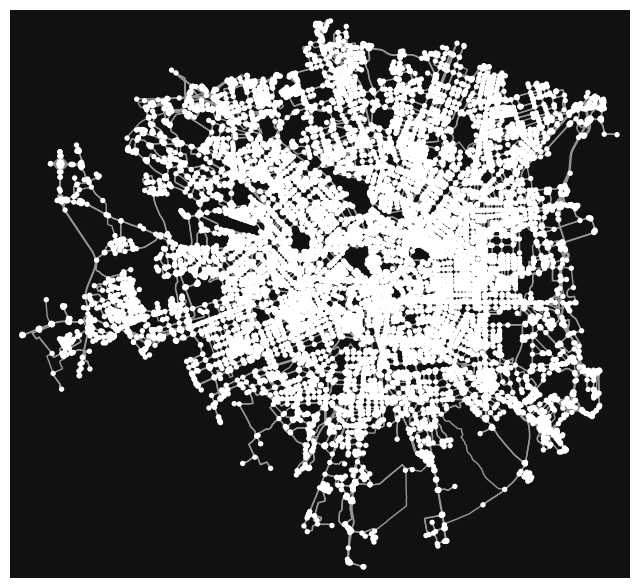

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
10371529,45.487563,9.076625,3,NaN,NaN,POINT (9.07662 45.48756)
10371530,45.479813,9.102055,3,NaN,NaN,POINT (9.10205 45.47981)
13595397,45.499516,9.130656,4,traffic_signals,NaN,POINT (9.13066 45.49952)
13598756,45.482757,9.163773,4,NaN,NaN,POINT (9.16377 45.48276)
13598788,45.487319,9.157376,3,NaN,NaN,POINT (9.15738 45.48732)


In [15]:
#In our example, OSMnx geocodes the query "Milan, Italy" to retrieve the place boundaries of that city
#from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, 
#constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends 
#and edges represent the street segments linking them.

G = osmnx_street_networks("Milan, Italy")
gdf_nodes = osmnx_graph_conversion(G)
gdf_nodes.head()

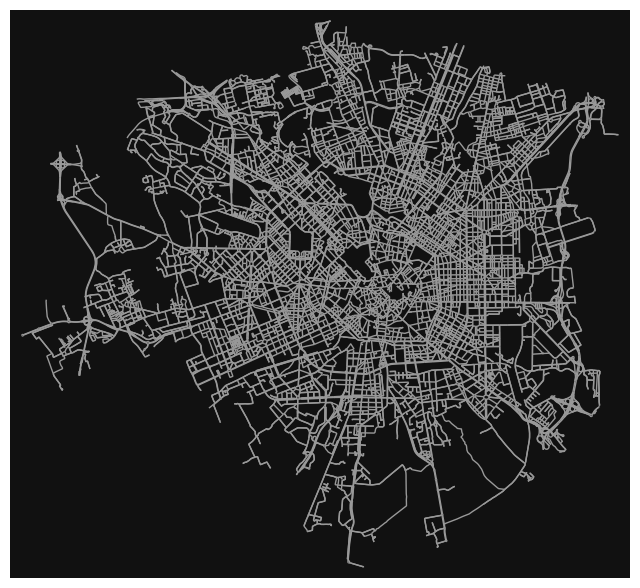

In [22]:
osmnx_networks_other_ways((37.870605, -122.254830), 1609, G)

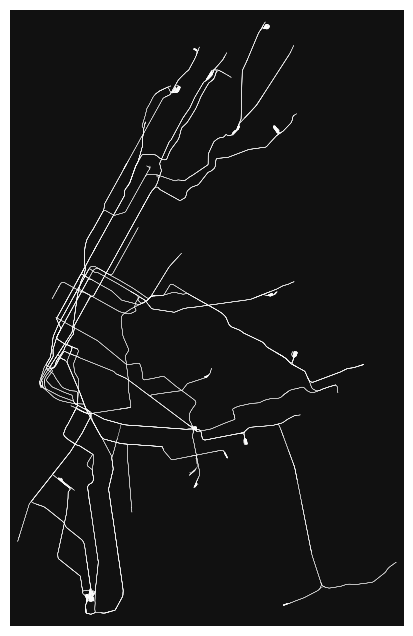

In [24]:
# For our example, we try to get NY subway rail network
osmnx_networks_by_custom_filter("New York, New York, USA", '["railway"~"subway"]')

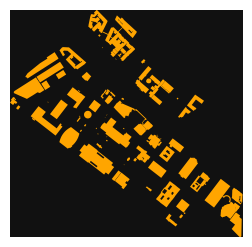

In [5]:
# get all building footprints in some neighborhood
osmnx_networks_by_tags("Civic Center, Los Angeles, California", {"building": True})